# Synthetic data test for robustness against interfering anomalies

This notebook generates the results and figures for section "Robustness against interfering anomalies".

----

### Note
This is an [IPython notebook](http://ipython.org/notebook.html), a document that incorporates text, results, figures, and the [Python](http://www.python.org/) source code to produce them. If you are viewing this from the URL http://nbviewer.ipython.org/, the document will be static (not executable). To run the code, you will need to download the notebook and install the software required. See the instructions at https://github.com/pinga-lab/Total-magnetization-of-spherical-bodies.

These numerical tests use the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://fatiando.org/).

----

## Setup

First, we'll import the required libraries and define some functions needed for error propagation.

In [1]:
%matplotlib inline
import numpy
import scipy
from scipy import sparse
from fatiando import mesher, gridder, gravmag
from fatiando.gravmag import sphere, prism, polyprism, fourier
from fatiando.gravmag.euler import Classic, ExpandingWindow
from fatiando.utils import ang2vec, contaminate, gaussian2d
from fatiando.vis import mpl, myv
from fatiando.gravmag.magdir import DipoleMagDir
import fatiando

In [2]:
print('Using Fatiando a Terra version {}'.format(fatiando.__version__))

Using Fatiando a Terra version 0.3


In [3]:
def uncertainty_L1(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L1 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    w = numpy.abs(solver.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1.0/w
    W = scipy.sparse.diags(w, 0)
    H = numpy.linalg.inv((solver.jacobian(p=None).T*W).dot(solver.jacobian(p=None))).dot(solver.jacobian(p=None).T)
    H = H*W
    dp = numpy.sqrt(numpy.diagonal((sigmad**2)*H.dot(H.T)))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

def uncertainty_L2(sigmad, solver):
    '''
    Calculate the uncertainty of the estimated
    intensities, inclinations and declinations
    obtained via L2 norm
    
    Parameters:
    
    * sigmad: float
        The uncertainty of the observed total field anomaly
        at all points.
    * solver: class:`fatiando.gravmag.magdir.DipoleMagDir`
        This class estimates the Cartesian components of the 
        magnetization vector of homogeneous dipolar bodies 
        with known center.

    Returns:
    
    * dh: list of arrays
        The uncertainties propagated from the observed data 
        to the estimated intensities, inclinations and 
        declinations of the magnetization vector of each 
        dipole.
    '''
    dp = numpy.sqrt(numpy.diagonal((sigmad**2)*numpy.linalg.inv(solver.jacobian(p=None).T.dot(solver.jacobian(p=None)))))
    dp = numpy.reshape(dp, (solver.ndipoles, 3))
    dh = []
    dhj = numpy.zeros(3)
    pj = numpy.zeros(3)
    i = 0
    for pj in numpy.reshape(solver.p_, (solver.ndipoles, 3)):
        aux0 = pj[0]**2 + pj[1]**2
        aux1 = numpy.sqrt(aux0)
        aux2 = 1.0/aux0
        aux3 = 1.0/aux1
        aux4 = 1.0/solver.estimate_[i][0]
        dQx, dQy, dQz = (pj*aux4)
        dIx = pj[0]*(-pj[2]*(aux4**2)*aux3)
        dIy = pj[1]*(-pj[2]*(aux4**2)*aux3)
        dIz = aux1*(aux4**2)
        dDx = -pj[1]*aux2
        dDy = pj[0]*aux2
        dhj[0] = (dQx*dp[i][0])**2 + (dQy*dp[i][1])**2 + (dQz*dp[i][2])**2
        dhj[1] = (dIx*dp[i][0])**2 + (dIy*dp[i][1])**2 + (dIz*dp[i][2])**2
        dhj[2] = (dDx*dp[i][0])**2 + (dDy*dp[i][1])**2
        dhj = numpy.sqrt(dhj)
        dh.append(dhj)
        i = i+1
    return dh

In [4]:
# Make noise-corrupted synthetic data
inc, dec = -10.0, -15.0 # inclination and declination of the Geomagnetic Field
incs = [-20.0, 30.0]
decs = [-10.0, -40.0]
ints = [6.0, 6.0]
dipole = [mesher.Sphere(3000, 3000, 1000, 1000, 
                       {'magnetization': ang2vec(ints[0], incs[0], decs[0])})]
prism = [mesher.Prism(6500, 7500, 6500, 7500, 200, 1200, 
                       {'magnetization': ang2vec(ints[1], incs[1], decs[1])})]

# Give the centers of the synthetic bodies
centers = [[3000, 3000, 1000], [7000, 7000, 700]] # list of Cartesian x, y, z coordinates

area = (0, 10000, 0, 10000)
x, y, z = gridder.scatter(area, 10000, z=-150, seed=0)
tf = gravmag.sphere.tf(x, y, z, dipole, inc, dec) + gravmag.prism.tf(x, y, z, prism, inc, dec)

# Interfering anomalies
sigma_x = [1000.0, 7000.0, 7000.0, 4000.0] # m
sigma_y = [7000.0, 200.0, 300.0, 2000.0] # m
x0 = [5000.0, 5000.0, 8000.0, 3330.0] # m
y0 = [1500.0, 5000.0, 5000.0, 5900.0] # m
amplitude = [500.0, 500.0, -500.0, -1200.0] # nT
angle = [0.0, 45.0, 45.0, 45.0]
gaussian  = amplitude[0]*gaussian2d(x, y, sigma_x[0], sigma_y[0], x0[0], y0[0], angle[0])

print 'gaussian maximum:', numpy.max(gaussian), 'nT'

gaussian maximum: 499.906284051 nT


total-field anomaly (without interference)
maximum: 747.950602095 nT
minimum: -1547.17549828 nT
total-field anomaly (with interference)
maximum: 957.158561025 nT
minimum: -1543.02205879 nT


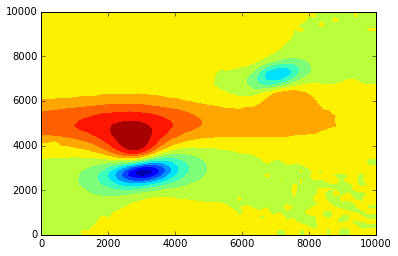

In [5]:
tf_interfering = tf + gaussian
uncertainty_data = 5.0 # nT
# Total field anomaly containated with Gaussian noise with zero 
# mean and standard deviation 5.0 nT
tf = contaminate(tf, uncertainty_data, seed = 345)

print 'total-field anomaly (without interference)'
print 'maximum:', numpy.max(tf), 'nT'
print 'minimum:', numpy.min(tf), 'nT'

# Total field anomaly with interfering sources and containated with 
# Gaussian noise with zero mean and standard deviation 5.0 nT
tf_interfering = contaminate(tf_interfering, uncertainty_data, seed = 345)

print 'total-field anomaly (with interference)'
print 'maximum:', numpy.max(tf_interfering), 'nT'
print 'minimum:', numpy.min(tf_interfering), 'nT'

nlevels = mpl.contourf(y, x, tf_interfering, (50,50), 15, interp=True, extrapolate=True)

/home/leo/bin/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1644: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


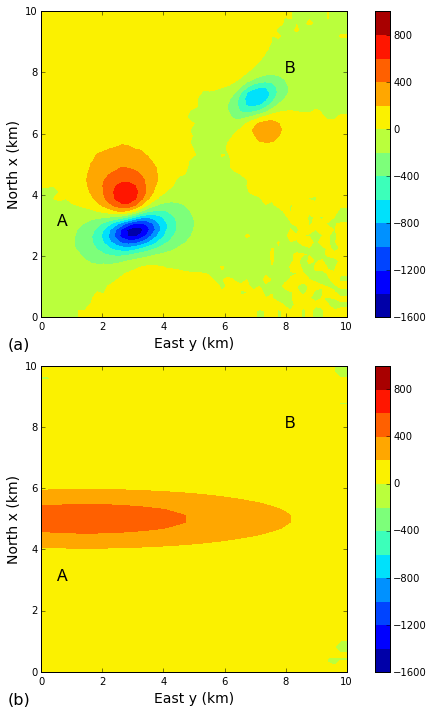

In [6]:
# Plot the data
mpl.close("all")

#mpl.figure(figsize = (14, 5))
mpl.figure(figsize = (8, 10), tight_layout = True)

tol = 0.05
smin = 0.001*numpy.min(x)
smax = 0.001*numpy.max(x)
smin = smin - tol*(smax - smin)
smax = smax + tol*(smax - smin)
tmin = 0.001*numpy.min(y)
tmax = 0.001*numpy.max(y)
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)

#mpl.subplot(1, 2, 1)
plt1 = mpl.subplot(2, 1, 1)
#mpl.title("(a)", fontsize = 16, loc = 'left')
#mpl.text(-1.3, -1.2, '(a)', fontsize=16)
mpl.text(smin-tol*(smax-smin), tmin-tol*(tmax-tmin), '(a)', fontsize=16)
mpl.text(0.5, 3.0, 'A', fontsize=16, family = 'arial')
mpl.text(8.0, 8.0, 'B', fontsize=16, family = 'arial')
mpl.axis('scaled')
mpl.contourf(0.001*y, 0.001*x, tf, (50,50), nlevels, interp=True, extrapolate=True)
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.colorbar()
#mpl.show()

#mpl.figure()
#mpl.subplot(1, 2, 2)
plt2 = mpl.subplot(2, 1, 2)
#mpl.title("(b)", fontsize = 16, loc = 'left')
#mpl.text(-1.3, -1.2, '(b)', fontsize=16)
mpl.text(smin-tol*(smax-smin), tmin-tol*(tmax-tmin), '(b)', fontsize=16)
mpl.text(0.5, 3.0, 'A', fontsize=16, family = 'arial')
mpl.text(8.0, 8.0, 'B', fontsize=16, family = 'arial')
mpl.axis('scaled')
mpl.contourf(0.001*y, 0.001*x, gaussian, (50,50), nlevels, interp=True, extrapolate=True)
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.colorbar()
mpl.show()

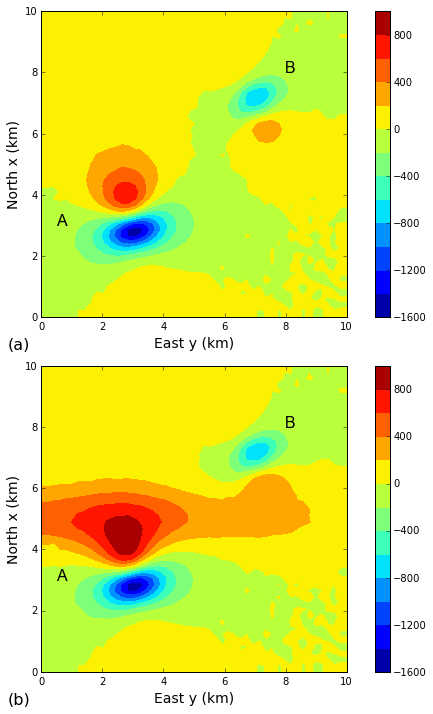

In [7]:
# Plot the data
mpl.close("all")

#mpl.figure(figsize = (14, 5))
mpl.figure(figsize = (8, 10), tight_layout = True)

tol = 0.05
smin = 0.001*numpy.min(x)
smax = 0.001*numpy.max(x)
smin = smin - tol*(smax - smin)
smax = smax + tol*(smax - smin)
tmin = 0.001*numpy.min(y)
tmax = 0.001*numpy.max(y)
tmin = tmin - tol*(tmax - tmin)
tmax = tmax + tol*(tmax - tmin)

#mpl.subplot(1, 2, 1)
plt1 = mpl.subplot(2, 1, 1)
#mpl.title("(a)", fontsize = 16, loc = 'left')
#mpl.text(-1.3, -1.2, '(a)', fontsize=16)
mpl.text(smin-tol*(smax-smin), tmin-tol*(tmax-tmin), '(a)', fontsize=16)
mpl.text(0.5, 3.0, 'A', fontsize=16, family = 'arial')
mpl.text(8.0, 8.0, 'B', fontsize=16, family = 'arial')
mpl.axis('scaled')
mpl.contourf(0.001*y, 0.001*x, tf, (50,50), nlevels, interp=True, extrapolate=True)
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.colorbar()
#mpl.show()

#mpl.figure()
#mpl.subplot(1, 2, 2)
plt2 = mpl.subplot(2, 1, 2)
#mpl.title("(b)", fontsize = 16, loc = 'left')
#mpl.text(-1.3, -1.2, '(b)', fontsize=16)
mpl.text(smin-tol*(smax-smin), tmin-tol*(tmax-tmin), '(b)', fontsize=16)
mpl.text(0.5, 3.0, 'A', fontsize=16, family = 'arial')
mpl.text(8.0, 8.0, 'B', fontsize=16, family = 'arial')
mpl.axis('scaled')
mpl.contourf(0.001*y, 0.001*x, tf_interfering, (50,50), nlevels, interp=True, extrapolate=True)
mpl.xlabel('East y (km)', fontsize = 14)
mpl.ylabel('North x (km)', fontsize = 14)
mpl.colorbar()
mpl.show()

In [8]:
# Estimate the magnetization vectors
#L2-norm estimate
solver_L2 = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit()

# L1-norm estimate
solver_L1 = DipoleMagDir(x, y, z, tf, inc, dec, centers).fit()
for i in range(100):
    w = numpy.abs(solver_L1.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver_L1.set_weights(w)
    solver_L1.fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)

# Print the estimated and true inclinations and declinations
print 'True'
for i in range(solver_L1.ndipoles):
    #print '%12.5e %12.5e' % (incs[i], decs[i])
    print '%12.5f %12.5f' % (incs[i], decs[i])
print 'Estimated L2'
for e in solver_L2.estimate_:
    #print '%12.5e %12.5e' % (e[1], e[2])
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L2'
for dhj in dh_L2:
    #print '%12.5e %12.5e' % (dhj[1], dhj[2])
    print '%12.5f %12.5f' % (dhj[1], dhj[2])
print 'Estimated L1'
for e in solver_L1.estimate_:
    #print '%12.5e %12.5e' % (e[1], e[2])
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L1'
for dhj in dh_L1:
    #print '%12.5e %12.5e' % (dhj[1], dhj[2])
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

True
   -20.00000    -10.00000
    30.00000    -40.00000
Estimated L2
   -19.99437    -10.07141
    31.04075    -40.63733
Uncertainties L2
     0.00000      0.00000
     0.00068      0.00113
Estimated L1
   -20.01263    -10.03229
    30.60570    -40.24551
Uncertainties L1
     0.00043      0.00090
     0.02067      0.03007


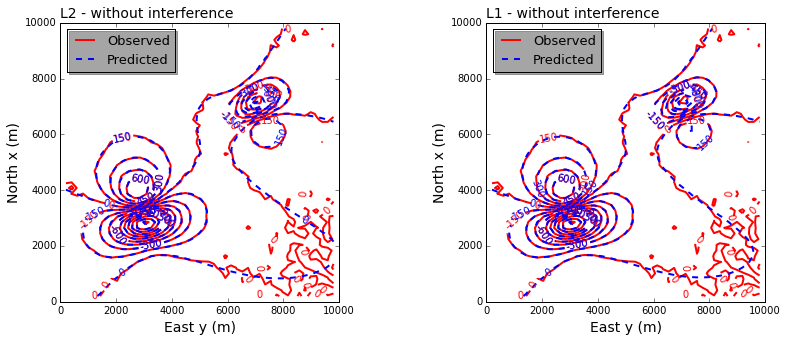

In [10]:
# Plot the observed and predicted data for the L1 and L2 estimates
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("L2 - without interference", fontsize = 14, loc = 'left')
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L2.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.subplot(1, 2, 2)
mpl.title("L1 - without interference", fontsize = 14, loc = 'left')
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L1.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.show()

In [12]:
# Estimate the magnetization vectors for the interfering anomaly

#L2-norm estimate
solver_L2 = DipoleMagDir(x, y, z, tf_interfering, inc, dec, centers).fit()

# L1-norm estimate
solver_L1 = DipoleMagDir(x, y, z, tf_interfering, inc, dec, centers).fit()
for i in range(100):
    w = numpy.abs(solver_L1.residuals())
    w[w < 10**(-10)] = 10**-10
    w = 1/w
    solver_L1.set_weights(w)
    solver_L1.fit()

# Calculate the uncertainties
dh_L2 = uncertainty_L2(uncertainty_data, solver_L2)
dh_L1 = uncertainty_L1(uncertainty_data, solver_L1)

# Print the estimated and true inclinations and declinations
print 'True'
for i in range(solver_L1.ndipoles):
    #print '%12.5e %12.5e' % (incs[i], decs[i])
    print '%12.5f %12.5f' % (incs[i], decs[i])
print 'Estimated L2'
for e in solver_L2.estimate_:
    #print '%12.5e %12.5e' % (e[1], e[2])
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L2'
for dhj in dh_L2:
    #print '%12.5e %12.5e' % (dhj[1], dhj[2])
    print '%12.5f %12.5f' % (dhj[1], dhj[2])
print 'Estimated L1'
for e in solver_L1.estimate_:
    #print '%12.5e %12.5e' % (e[1], e[2])
    print '%12.5f %12.5f' % (e[1], e[2])
print 'Uncertainties L1'
for dhj in dh_L1:
    #print '%12.5e %12.5e' % (dhj[1], dhj[2])
    print '%12.5f %12.5f' % (dhj[1], dhj[2])

True
   -20.00000    -10.00000
    30.00000    -40.00000
Estimated L2
   -25.11757     -4.28547
    39.08012    -23.63607
Uncertainties L2
     0.00000      0.00000
     0.00064      0.00130
Estimated L1
   -21.75561     -8.73921
    33.40894    -39.37565
Uncertainties L1
     0.00011      0.00031
     0.01051      0.01752


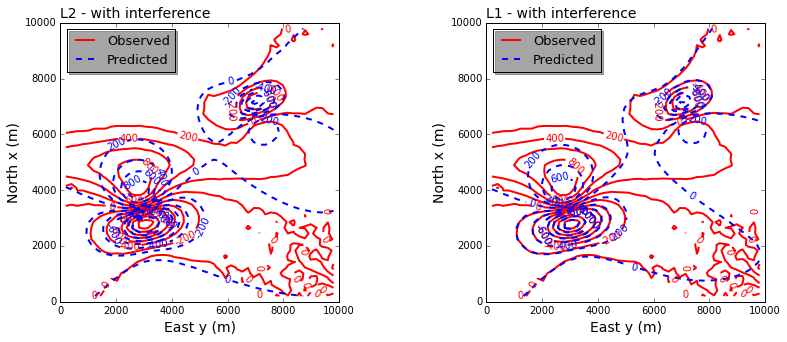

In [13]:
# Plot the observed and predicted data for the L1 and L2 estimates
mpl.close("all")
mpl.figure(figsize=(14, 5))
mpl.subplot(1, 2, 1)
mpl.title("L2 - with interference", fontsize = 14, loc = 'left')
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf_interfering, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L2.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.subplot(1, 2, 2)
mpl.title("L1 - with interference", fontsize = 14, loc = 'left')
mpl.axis('scaled')
nlevels = mpl.contour(y, x, tf_interfering, (50,50), 15, interp=True, color='r', label='Observed', 
            clabel=True, style='solid', linewidth=2.0)
mpl.contour(y, x, solver_L1.predicted(), (50,50), nlevels, interp=True, color='b', label='Predicted', 
            clabel=True, style='dashed', linewidth=2.0)
mpl.legend(loc='upper left', shadow=True, prop={'size':13})
mpl.xlabel('East y (m)', fontsize = 14)
mpl.ylabel('North x (m)', fontsize = 14)
mpl.show()